[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/image-retrieval/vision-transformers/vit.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/image-retrieval/vision-transformers/vit.ipynb)

# Vision Transformers (ViT) Walkthrough

# Vision Transformers (ViT)
Note this notebook is based on explanation from this blog:https://www.pinecone.io/learn/vision-transformers/ and for more information on Transformers look at the youtube video: https://youtu.be/qU7wO02urYU

Vision and language are the two big domains in machine learning. Two distinct disciplines with their own problems, best practices, and model architectures. At least, that was the case.

The Vision Transformer (ViT) marks the first step towards the merger of these two fields into a single unified discipline. For the first time in the history of ML, a single model architecture has come to dominate both language and vision.

- Before ViT, transformers were “those language models” and nothing more.

- In NLP, Attention mechanism allows us to embed the contextual meaning into the model. Attention allows you to identify that relationship between wordings in a sentence.

![Attention Mechanism](./images/attention-mechanism.png)

- Attention mechanism allows tokens (a vector for each word) to be embedded in the same space if they are similar, and a different space if they are different. This is done by a dot product.

- Attention mechanism should be applied in later layers of a CNN network, as the dimension can be very big if we apply it at the start.

![CNN](./images/where-to-apply-attention-mechanism-cnn.png)

- BERT is a transform model that contains several encoder layers. Now, withing each encoder layers, you have encoder blocks, which consists of a normalisation, multi-head attention (many attention mechanism happening in parallel), and an MLP.

![Encoder-blocks](./images/encoder-blocks.png)

- Differences between NLP and Computer vision.
In NLP, we convert each word in a sentence to a token. In Computer vision, we convert an image into image patches.

![NLP-CNN](./images/Diff-btw-NLP-Computer-vision.png)

- BERT introduced the CLS or classifier tokens to every sentences, this is appended to every sentences after passing through the BERT tokenizer.
![CLS](./images/CLS.png)

- ViT adds a class embedding or learnable embedding to the image patch embedding. it's very important if we want to perform classification. 

![Vision-Class-embedding](./images/class-embedding-vision.png)

- Positonal embedding needs to be added to ViT as transformers by default does not have any mechanism for tracking the position of the image patches or words tokens for NLP. The order of words in NLP is incredibly important, hence it's important to keep track of the order/time.

- Once we added the learnable positional embeddding and the patch embedding, we pass that throught the Vision transformer model.


In [2]:
!pip install datasets transformers torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Let's start by downloading the CIFAR-10 dataset from HuggingFace. We will first download the training dataset by setting ```split = 'train'```, and the testing dataset after by setting ```split = 'test'```.

In [3]:
# import CIFAR-10 dataset from HuggingFace
from datasets import load_dataset

dataset_train = load_dataset(
    'cifar10',
    split='train', # training dataset
    ignore_verifications=False  # set to True if seeing splits Error
)

dataset_train

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.8/dist-packages/datasets/features/image.py:319: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [4]:
dataset_test = load_dataset(
    'cifar10',
    split='test', # training dataset
    ignore_verifications=True  # set to True if seeing splits Error
)

dataset_test

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [5]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(10,
 ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None))

*Training*: 50,000 images divided into 10 classes

*Test*: 10,000 images divided into 10 classes

In [6]:
dataset_train[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FDC6BDC2550>,
 'label': 0}

Those are PIL images with $3$ color channels, and $32x32$ pixels resolution. Let's have a look at the first picture in the dataset.

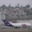

In [7]:
dataset_train[0]['img']

In [8]:
dataset_train[0]['label'], labels.names[dataset_train[0]['label']]

(0, 'airplane')

### Loading ViT Feature Extractor

We use `google/vit-base-patch16-224-in21k` model from the Hugging Face Hub.

The model is named as so as it refers to base-sized architecture with patch resolution of 16x16 and fine-tuning resolution of 224x224.  

In [9]:
from transformers import ViTFeatureExtractor

# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


You can see the feature extractor configuration by printing it

In [10]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

If we consider the first image, i.e., the airplane shown above, we can see the resulting tensor after passing the image through the feature extractor. 

In [11]:
example = feature_extractor(
    dataset_train[0]['img'],
    return_tensors='pt'
)
example

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [12]:
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [13]:
# load in relevant libraries, and alias where appropriate
import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['img'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['label']
    return inputs

We can apply this to both the training and testing dataset.

In [15]:
# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)

Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices).

### Model Fine-Tuning

In this section, we are going to build the Trainer, which is a feature-complete training and eval loop for PyTorch, optimized for HuggingFace 🤗 Transformers.

We need to define all of the arguments that it will include:
* training and testing dataset
* feature extractor
* model
* collate function
* evaluation metric
* ... other training arguments.

The collate function is useful when dealing with lots of data. Batches are lists of dictionaries, so collate will help us create batch tensors.

In [16]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Let's now define the evaluation metric we are going to use to compare prediction with actual labels. We will use the *accuracy evaluation metric*. 

Accuracy is defined as the proportion of correct predictions (True Positive ($TP$) and True Negative ($TN$)) among the total number of cases processed ($TP$, $TN$, False Positive ($FP$), and False Negative ($FN$)). 

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$    

Below, we are using accuracy within the ```compute_metrics``` function.

In [17]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

<ipython-input-17-b7bbca42f0bd>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The last thing consists of defining ```TrainingArguments```.

Most of these are pretty self-explanatory, but one that is quite important here is ```remove_unused_columns=False```. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

We have chosen a batch size equal to 16, 100 evaluation steps, and a learning rate of $2e^{-4}$.

In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./cifar",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=1,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

We can now load the pre-trained model. We'll add ```num_labels``` on init so the model creates a classification head with the right number of units.

In [19]:
from transformers import ViTForImageClassification

labels = dataset_train.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=len(labels)
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

We can see the characteristics of our model.

Now, all instances can be passed to ```Trainer```.

In [21]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

We can save our trained model.

In [22]:
train_results = trainer.train()
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3125
  Number of trainable parameters = 85806346


Step,Training Loss,Validation Loss,Accuracy
100,0.453300,0.390455,0.918200
200,0.319000,0.435766,0.883900
300,0.390700,0.336643,0.905700
400,0.312000,0.336158,0.905000
500,0.240200,0.365294,0.892400
600,0.339300,0.319690,0.908800
700,0.186900,0.366192,0.901200
800,0.324500,0.217410,0.935300
900,0.297100,0.220066,0.934600
1000,0.195500,0.275259,0.921500


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to ./cifar/checkpoint-100
Configuration saved in ./cifar/checkpoint-100/config.json
Model weights saved in ./cifar/checkpoint-100/pytorch_model.bin
Image processor saved in ./cifar/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to ./cifar/checkpoint-200
Configuration saved in ./cifar/checkpoint-200/config.json
Model weights saved in ./cifar/checkpoint-200/pytorch_model.bin
Image processor saved in ./cifar/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to ./cifar/checkpoint-300
Configuration saved in ./cifar/checkpoint-300/config.json
Model weights saved in ./cifar/checkpoint-300/pytorch_model.bin
Image processor saved in ./cifar/checkpoint-300/preprocessor_config.json
Deleting older checkpoint [cifar/checkpoint-100] due

***** train metrics *****
  epoch                    =          1.0
  total_flos               = 3608760698GF
  train_loss               =       0.2033
  train_runtime            =   1:40:46.12
  train_samples_per_second =         8.27
  train_steps_per_second   =        0.517


#### Model Evaluation

We can now evaluate our model using the accuracy metric defined above...

In [23]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


***** eval metrics *****
  epoch                   =        1.0
  eval_accuracy           =     0.9815
  eval_loss               =     0.0644
  eval_runtime            = 0:02:11.81
  eval_samples_per_second =     75.866
  eval_steps_per_second   =      9.483


Model accuracy is pretty good. Let's have a look to an example. We can pick the first image in our testing dataset and see if the predicted label is correct.

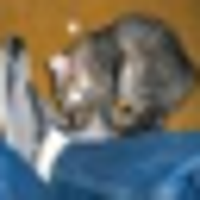

In [24]:
# show the first image of the testing dataset
image = dataset_test["img"][0].resize((200,200))
image

The image is not very clear, even when resized. Let's extract the actual label.

In [25]:
# extract the actual label of the first image of the testing dataset
actual_label = dataset_test["label"][0]

labels = dataset_test.features['label']
actual_label, labels.names[actual_label]


(3, 'cat')

It looks like the image represents a cat. Let's now see what our model has predicted. Given we saved it on the HuggingFace Hub, we first need to import it. We can use ViTForImageClassification and ViTFeatureExtractor to import the model and extract its features. We would need the predicted pixel values "pt".

In [26]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
model_name_or_path = 'LaCarnevali/vit-cifar10'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--LaCarnevali--vit-cifar10/snapshots/b363d25658445576de954eb3a8bd5bcaf5e3cbe9/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "airplane": "0",
    "automobile": "1",
    "bird": "2",
    "cat": "3",
    "deer": "4",
    "dog": "5",
    "frog": "6",
    "horse": "7",
    "ship": "8",
    "truck": "9"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attentio

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--LaCarnevali--vit-cifar10/snapshots/b363d25658445576de954eb3a8bd5bcaf5e3cbe9/pytorch_model.bin
All model checkpoint weights were used when initializing ViTForImageClassification.

All the weights of ViTForImageClassification were initialized from the model checkpoint at LaCarnevali/vit-cifar10.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ViTForImageClassification for predictions without further training.


loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--LaCarnevali--vit-cifar10/snapshots/b363d25658445576de954eb3a8bd5bcaf5e3cbe9/preprocessor_config.json
/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.0039215

In [27]:
inputs = feature_extractor_finetuned(image, return_tensors="pt")

with torch.no_grad():
    logits = model_finetuned(**inputs).logits

We can now see what is our predicted label. Do extract it, we can use the argmax function.

In [28]:
predicted_label = logits.argmax(-1).item()
labels = dataset_test.features['label']
labels.names[predicted_label]

'cat'

And the answer is cat. Which is what we would expect.

## References

[Article](https://pinecone.io/learn/vision-transformers/)

[1] Dosovitskiy et al., [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), 2021, CV.

[2] Vaswani et al., [Attention Is All You Need](https://arxiv.org/abs/1706.03762), 2017.

[3] Saeed M., [A Gentle Introduction to Positional Encoding in Transformer Models, Part 1](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/), 2022, Attention, Machine Learning Mastery.